In [100]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import pandas_ta as ta ## Technical Analysis Indicators
import yfinance as yf
data = yf.download(tickers = 'BTC-USD', start = '2012-03-11',end = '2022-07-10')
data.head(10)



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400


In [101]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [102]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15) ## Relative Strength Index
data['EMAF']=ta.ema(data.Close, length=20) ## Exponential Moving Average Fast
data['EMAM']=ta.ema(data.Close, length=100) ## Exponential Moving Average Medium
data['EMAS']=ta.ema(data.Close, length=150) ## Exponential Moving Average Slow

data['Target'] = data['Adj Close']-data.Open ## Target is the difference between the opening price and the future closing price
data['Target'] = data['Target'].shift(-1) ## Shift the target by one day

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))] ## TargetClass is 1 if the price goes up and 0 if it goes down

data['TargetNextClose'] = data['Adj Close'].shift(-1) ## TargetNextClose is the future closing price

data.dropna(inplace=True) ## Drop the NaN values
data.reset_index(inplace = True) ## Reset the index
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True) ## Drop the columns that are not needed

In [104]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,221.968994,240.259003,221.261993,235.427002,50.019072,229.312807,288.640505,327.932773,21.793015,1,257.321014
1,235.528000,259.808014,235.528000,257.321014,58.174526,231.980256,288.020317,326.997518,-22.681992,0,234.824997
2,257.506989,265.610992,227.684006,234.824997,49.315763,232.251183,286.966944,325.776690,-0.981995,0,233.843002
3,234.824997,239.520996,229.022003,233.843002,48.967016,232.402785,285.914985,324.559025,10.188004,1,243.610001
4,233.421997,245.774994,232.313995,243.610001,52.543343,233.470139,285.077263,323.486853,-7.453995,0,236.326004
5,243.779999,244.251007,232.339996,236.326004,49.757135,233.742126,284.111891,322.332404,3.873001,1,240.283005
6,236.410004,242.671997,235.591995,240.283005,51.261414,234.365067,283.243992,321.245657,3.528000,1,243.779007
7,240.251007,247.100998,239.298996,243.779007,52.604668,235.261633,282.462508,320.219609,0.781998,1,244.533997
8,243.751999,255.320007,243.184006,244.533997,52.904994,236.144715,281.711448,319.217151,-8.567001,0,235.977005
9,244.544006,246.391998,233.850998,235.977005,49.124904,236.128743,280.805815,318.114632,2.897003,1,238.891998


In [105]:
from sklearn.preprocessing import MinMaxScaler ## Scale the data
sc = MinMaxScaler(feature_range=(0,1)) ## Scale the data between 0 and 1
data_set_scaled = sc.fit_transform(data_set) ## Fit and transform the data
print(data_set_scaled) ## Print the scaled data

[[1.76730917e-04 2.39565673e-04 3.27805591e-04 ... 5.10015892e-01
  1.00000000e+00 6.95198463e-04]
 [3.78083351e-04 5.24678857e-04 5.43361175e-04 ... 5.07025701e-01
  0.00000000e+00 3.61213277e-04]
 [7.04473276e-04 6.09312584e-04 4.24840499e-04 ... 5.08484658e-01
  0.00000000e+00 3.46634179e-04]
 ...
 [2.96772352e-01 2.97111660e-01 2.96512614e-01 ... 5.81819495e-01
  1.00000000e+00 3.18115490e-01]
 [3.02017333e-01 3.14267258e-01 3.03653351e-01 ... 5.14868094e-01
  1.00000000e+00 3.19504064e-01]
 [3.18194126e-01 3.22188482e-01 3.18179089e-01 ... 5.00172022e-01
  0.00000000e+00 3.17441747e-01]]


In [106]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 10 ## Number of previous candles(days) to consider
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2]) 

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2703
[[[1.76730917e-04 2.39565673e-04 3.27805591e-04 ... 0.00000000e+00
   8.54480830e-04 1.51359471e-03]
  [3.78083351e-04 5.24678857e-04 5.43361175e-04 ... 4.23545789e-05
   8.43149654e-04 1.49563545e-03]
  [7.04473276e-04 6.09312584e-04 4.24840499e-04 ... 4.66564543e-05
   8.23903952e-04 1.47219246e-03]
  ...
  [4.48220425e-04 3.39352973e-04 6.00339929e-04 ... 9.44573109e-05
   7.41605401e-04 1.36548248e-03]
  [5.00210464e-04 4.59223380e-04 6.59041399e-04 ... 1.08479168e-04
   7.27883126e-04 1.34623274e-03]
  [5.11971844e-04 3.29012545e-04 5.18022119e-04 ... 1.08225553e-04
   7.11336719e-04 1.32506160e-03]]

 [[3.78083351e-04 5.24678857e-04 5.43361175e-04 ... 4.23545789e-05
   8.43149654e-04 1.49563545e-03]
  [7.04473276e-04 6.09312584e-04 4.24840499e-04 ... 4.66564543e-05
   8.23903952e-04 1.47219246e-03]
  [3.67643695e-04 2.28802192e-04 4.45057286e-04 ... 4.90636352e-05
   8.04684075e-04 1.44881023e-03]
  ...
  [5.00210464e-04 4.59223380e-04 6.59041399e-04 ... 1.08479168e-04
   7.

In [107]:
# split data into train test sets
splitlimit = int(len(X)*0.8) ## Split the data into 80% training and 20% testing
print(splitlimit) ## Print the split limit to check
X_train, X_test = X[:splitlimit], X[splitlimit:] ## Split the data into training and testing
y_train, y_test = y[:splitlimit], y[splitlimit:] ## Split the data into training and testing
print(X_train.shape) ## Print the shape of the training data
print(X_test.shape) ## Print the shape of the testing data
print(y_train.shape) ## Print the shape of the training data
print(y_test.shape) ## Print the shape of the testing data
print(y_train) ## Print the training data

2154
(2154, 10, 8)
(539, 10, 8)
(2154, 1)
(539, 1)
[[4.19262810e-04]
 [4.00482105e-04]
 [3.84982355e-04]
 ...
 [5.78666197e-01]
 [5.43599547e-01]
 [5.33990554e-01]]


In [108]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [109]:
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model1 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()


model1.summary()



Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 8)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               95400     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 95551 (373.25 KB)
Trainable params: 95551 (373.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(optimizer=adam, loss='mae')


In [113]:
model1.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=15, epochs=30, shuffle=True, validation_split = 0.1, callbacks=[cp1])

Epoch 1/30
140/144 [============================>.] - ETA: 0s - loss: 0.0088INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 3s 18ms/step - loss: 0.0087 - val_loss: 0.0361
Epoch 2/30
140/144 [============================>.] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 3s 19ms/step - loss: 0.0053 - val_loss: 0.0326
Epoch 3/30
137/144 [===========================>..] - ETA: 0s - loss: 0.0052INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0322
Epoch 4/30
137/144 [===========================>..] - ETA: 0s - loss: 0.0051INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 2s 16ms/step - loss: 0.0050 - val_loss: 0.0311
Epoch 5/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0422
Epoch 6/30
136/144 [===========================>..] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 3s 18ms/step - loss: 0.0044 - val_loss: 0.0302
Epoch 7/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0344
Epoch 8/30
139/144 [===========================>..] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 2s 16ms/step - loss: 0.0045 - val_loss: 0.0285
Epoch 9/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0346
Epoch 10/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0044 - val_loss: 0.0346
Epoch 11/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0311
Epoch 12/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0317
Epoch 13/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0045 - val_loss: 0.0399
Epoch 14/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0315
Epoch 15/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0397
Epoch 16/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0403
Epoch 17/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0320
Ep

INFO:tensorflow:Assets written to: model1/assets


144/144 [==============================] - 2s 16ms/step - loss: 0.0040 - val_loss: 0.0283
Epoch 22/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0337
Epoch 23/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0332
Epoch 24/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0453
Epoch 25/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.1002
Epoch 26/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.2906
Epoch 27/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.2153
Epoch 28/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.1920
Epoch 29/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0040 - val_loss: 0.1252
Epoch 30/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0732


In [114]:
from keras.models import load_model
model1 = load_model('model1/')

In [115]:
y_pred = model1.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

17/17 [==============================] - 0s 4ms/step
[0.537819] [0.52824702]
[0.55664283] [0.54070015]
[0.52895945] [0.53238215]
[0.55468524] [0.52463151]
[0.5444392] [0.45452599]
[0.52532536] [0.4868921]
[0.46995628] [0.4729644]
[0.49547824] [0.47625639]
[0.48350766] [0.47739976]
[0.48238322] [0.48042037]


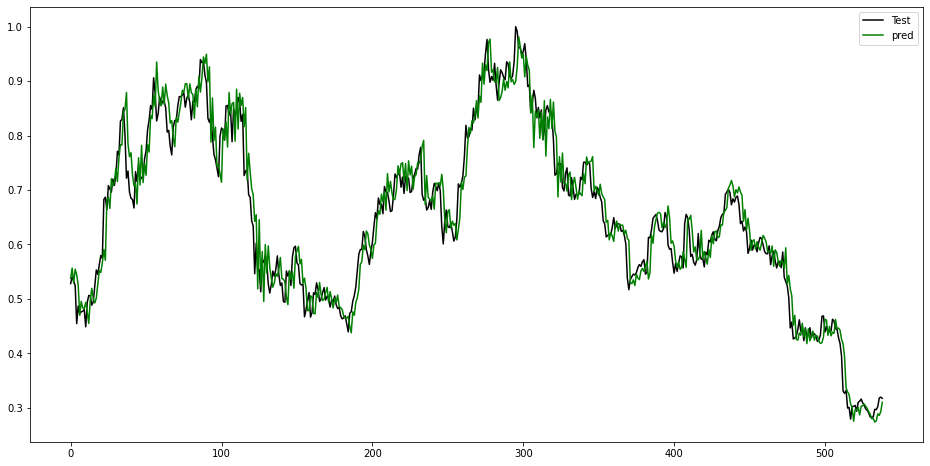

AttributeError: module 'keras.api._v2.keras.metrics' has no attribute 'mean_square_error'

In [133]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()
print(tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

